In [1]:
from lifelines import CoxPHFitter, plotting, KaplanMeierFitter
from lifelines.utils import k_fold_cross_validation, concordance_index
from lifelines.calibration import survival_probability_calibration
from lifelines.datasets import load_rossi
import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
from tableone import TableOne

import matplotlib.pyplot as plt
import seaborn as sns

/Users/bruna/miniconda3/envs/fairness-health/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Rossi dataset

In [2]:
# This data set is originally from Rossi et al. (1980), and is used as an example in Allison (1995). 
# The data pertain to 432 convicts who were released from Maryland state prisons in the 1970s and who were 
# followed up for one year after release. Half the released convicts were assigned at random to an experimental 
# treatment in which they were given financial aid; half did not receive aid.
#
# The following variables are included in the data:
#
# week: week of first arrest after release, or censoring time.
# arrest: the event indicator, equal to 1 for those arrested during the period of the study and 0 for those who were not arrested.
# fin: a factor, equal to 1 if the individual received financial aid after release from prison, and 0 if he did not; financial aid was a randomly assigned factor manipulated by the researchers.
# age: in years at the time of release.
# race: a factor, equal to 1 if black and 0 if other.
# wexp: a factor, equal to 1 if the individual had full-time work experience prior to incarceration and equalt to 0 if he did not.
# mar: a factor, equal to 1 if the individual was married at the time of release and 0 if he was not.
# paro: a factor, equal to 1 if the individual was released on parole and 0 if he was not.
# prio: number of prior convictions.
#
# PS: The principal purpose of the recidivism study was to assess the impact of financial aid on rearrest.

rossi_df = load_rossi()

In [3]:
rossi_df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


### Dataframe analysis

In [85]:
rossi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   week    432 non-null    int64
 1   arrest  432 non-null    int64
 2   fin     432 non-null    int64
 3   age     432 non-null    int64
 4   race    432 non-null    int64
 5   wexp    432 non-null    int64
 6   mar     432 non-null    int64
 7   paro    432 non-null    int64
 8   prio    432 non-null    int64
dtypes: int64(9)
memory usage: 30.5 KB


[]

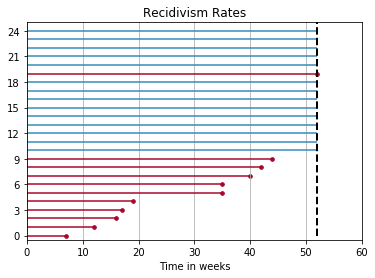

In [86]:
# Plotting only n individuals
df = rossi_df.sample(n=25, random_state=42)

durations = df.week.values
events = df.arrest.values

ax = plotting.plot_lifetimes(durations=durations, event_observed=events)
ax.set_xlim(0, 60)
ax.vlines(52, 0, 25, lw=2, linestyles='--')
ax.grid(axis='x')
ax.set_xlabel("Time in weeks")
ax.set_title("Recidivism Rates")
plt.plot()

In [87]:
# Table One
columns = ["arrest", "fin", "wexp", "mar", "paro"]
groupby = ['race']
nonnormal = ["age"]

# create an instance of TableOne with the input arguments
grouped_table = TableOne(rossi_df, columns=columns, groupby=groupby, nonnormal=nonnormal, missing=False)

# view tableone
grouped_table

Grouped by race            
                       0           1
n                     53         379
arrest 0       41 (77.4)  277 (73.1)
       1       12 (22.6)  102 (26.9)
fin    0       31 (58.5)  185 (48.8)
       1       22 (41.5)  194 (51.2)
wexp   0       20 (37.7)  165 (43.5)
       1       33 (62.3)  214 (56.5)
mar    0       44 (83.0)  335 (88.4)
       1        9 (17.0)   44 (11.6)
paro   0       23 (43.4)  142 (37.5)
       1       30 (56.6)  237 (62.5)

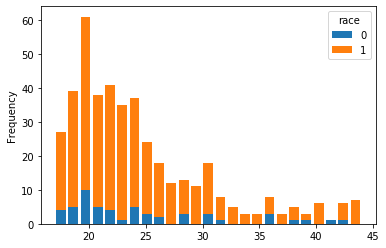

In [88]:
# age distribution
rossi_df.pivot(columns='race').age.plot(kind = 'hist', stacked=True, bins=25, rwidth=0.8)

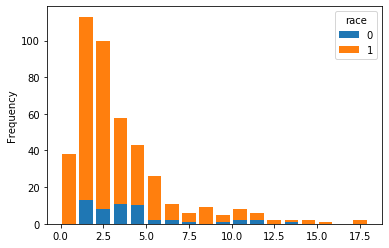

In [89]:
# prior arrest distribution
rossi_df.pivot(columns='race').prio.plot(kind = 'hist', stacked=True, bins=18, rwidth=0.8)

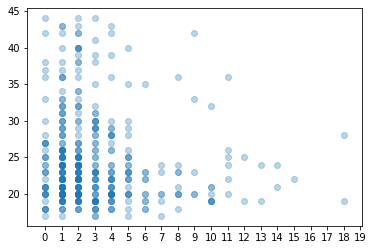

In [90]:
# Prior arrests by age
x = rossi_df["prio"]
y = rossi_df["age"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, 20, 1)
ax.set_xticks(major_ticks)
plt.scatter(x, y, alpha=0.3)

### Model

#### Kaplan Meier

In [10]:
T = rossi_df["week"]
E = rossi_df["arrest"]

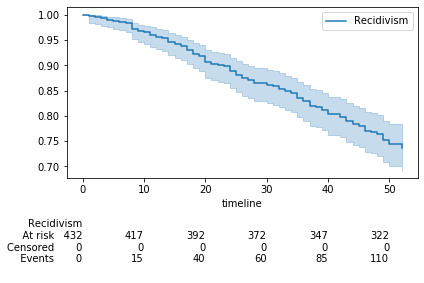

In [9]:
kmf = KaplanMeierFitter().fit(T, E, label="Recidivism")
kmf.plot_survival_function(at_risk_counts=True)
plt.tight_layout()

#### Cox

In [91]:
rossi_df = rossi_df.drop('age', axis=1)

In [92]:
cph = CoxPHFitter()
formula="fin + mar + prio + paro + wexp + race + fin*mar + fin*prio + fin*paro + fin*wexp + fin*race + mar*prio + mar*paro + mar*wexp + mar*race + prio*paro + prio*wexp + prio*race + paro*wexp + paro*race + wexp*race"
cph.fit(rossi_df, duration_col='week', event_col='arrest', formula=formula)

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -652.63
         time fit was run = 2020-12-23 17:49:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.27       0.76       0.80            -1.85             1.30                 0.16                 3.67
mar        -0.99       0.37       2.30            -5.49             3.52                 0.00                33.73
prio        0.25       1.28       0.11             0.04             0.46                 1.04                 1.58
paro       -1.52       0.22       0.82            -3.13             0.09                 0.04                 1.09
wexp       -0.16       0.85       0.74            -1.60             1.28                 0.20                 3.61
race        0.42       1.53       0.71            -0.97             1.82                 0.38                 6.15
fin:mar     0.48       1.62       0.95            -1.37             2.34                 0.25                10.38
fin:prio   -0.07       0.93       0.06            -0.19             0.05                 0.83                 1.05
fin:paro    0.75       2.12       0.42            -0.08             1.58                 0.92                 4.86
fin:wexp   -0.22       0.80       0.41            -1.03             0.59                 0.36                 1.81
fin:race   -0.26       0.77       0.70            -1.62             1.10                 0.20                 3.01
mar:prio   -0.01       0.99       0.20            -0.41             0.39                 0.67                 1.48
mar:paro    1.40       4.07       1.24            -1.03             3.84                 0.36                46.32
mar:wexp   -2.82       0.06       0.89            -4.57            -1.07                 0.01                 0.34
mar:race    1.35       3.85       2.04            -2.64             5.34                 0.07               208.02
prio:paro  -0.00       1.00       0.06            -0.12             0.11                 0.89                 1.12
prio:wexp   0.05       1.05       0.07            -0.10             0.19                 0.90                 1.21
prio:race  -0.13       0.88       0.10            -0.32             0.07                 0.73                 1.07
paro:wexp   0.17       1.18       0.42            -0.67             1.00                 0.51                 2.71
paro:race   1.19       3.28       0.71            -0.20             2.57                 0.82                13.10
wexp:race  -0.20       0.82       0.67            -1.50             1.11                 0.22                 3.03

              z      p   -log2(p)
covariate                        
fin       -0.34   0.73       0.45
mar       -0.43   0.67       0.58
prio       2.29   0.02       5.52
paro      -1.85   0.06       3.96
wexp      -0.22   0.83       0.27
race       0.60   0.55       0.86
fin:mar    0.51   0.61       0.71
fin:prio  -1.11   0.27       1.91
fin:paro   1.77   0.08       3.71
fin:wexp  -0.53   0.60       0.74
fin:race  -0.38   0.71       0.50
mar:prio  -0.04   0.97       0.04
mar:paro   1.13   0.26       1.96
mar:wexp  -3.16 <0.005       9.33
mar:race   0.66   0.51       0.98
prio:paro -0.08   0.94       0.09
prio:wexp  0.61   0.54       0.88
prio:race -1.28   0.20       2.32
paro:wexp  0.39   0.70       0.52
paro:race  1.68   0.09       3.43
wexp:race -0.29   0.77       0.38
---
Concordance = 0.67
Partial AIC = 1347.26
log-likelihood ratio test = 45.50 on 21 df
-log2(p) of ll-ratio test = 9.39

In [93]:
cph.check_assumptions(rossi_df)

Proportional hazard assumption looks okay.


[]

In [94]:
scores = k_fold_cross_validation(cph, rossi_df, duration_col='week', event_col='arrest', k=10, scoring_method="concordance_index")
print(np.mean(scores))

0.6004732960771306


In [96]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 389 total observations, 287 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 389
number of events observed = 102
   partial log-likelihood = -582.33
         time fit was run = 2020-12-23 17:49:36 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.69       0.20            -0.77             0.02                 0.46                 1.02
race        0.18       1.20       0.32            -0.45             0.81                 0.64                 2.25
wexp       -0.38       0.69       0.22            -0.80             0.04                 0.45                 1.05
mar        -0.74       0.48       0.43            -1.59             0.11                 0.20                 1.12
paro       -0.07       0.93       0.20            -0.47             0.33                 0.62                 1.40
prio        0.08       1.08       0.03             0.02             0.14                 1.02                 1.15

              z    p   -log2(p)
covariate                      
fin       -1.87 0.06       4.02
race       0.57 0.57       0.82
wexp      -1.75 0.08       3.65
mar       -1.70 0.09       3.48
paro      -0.33 0.74       0.44
prio       2.59 0.01       6.71
---
Concordance = 0.63
Partial AIC = 1176.66
log-likelihood ratio test = 22.77 on 6 df
-log2(p) of ll-ratio test = 10.15

### Covariates

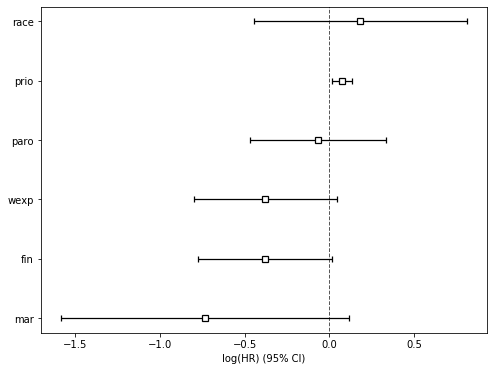

In [97]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])

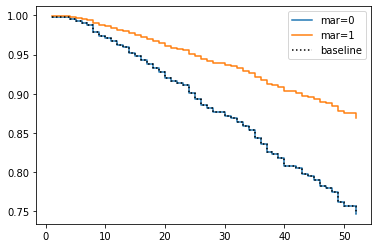

In [98]:
cph.plot_partial_effects_on_outcome('mar', values=np.arange(0, 2, 1))

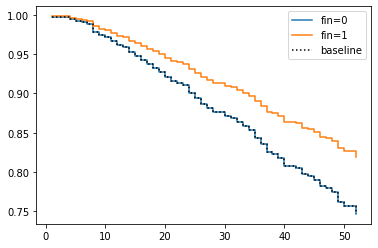

In [99]:
cph.plot_partial_effects_on_outcome('fin', values=np.arange(0, 2, 1))

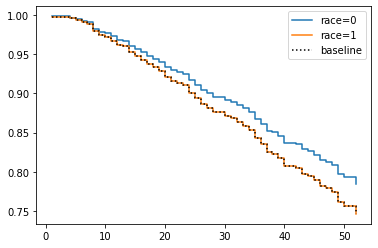

In [100]:
cph.plot_partial_effects_on_outcome('race', values=np.arange(0, 2, 1))

## Fairness

Survival rates (S(t)) simply gives us the probability that event will not occur beyond time t, in this case, rearrest.

In [101]:
def survival_curve_plot(surv1, surv2, label1, label2):

    df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2 = survival_curve_median_calc(surv1, surv2)

    # Compute stats: tests whether 2 samples are drawn from the same distribution
    # H0: samples are drawn from the same distribution
    # H1: samples are not drawn from the same distribution
    
    # If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis 
    # that the distributions of the two samples are the same.
    test = compute_stats(df_surv_median1, df_surv_median2)

    # Plot curves 
    ax = plt.subplots(figsize=(8, 6))
    
    # 95% Confidence interval
    ci1_left = surv1.quantile(0.025, axis=1)
    ci1_right = surv1.quantile(0.975, axis=1)
    ci2_left = surv2.quantile(0.025, axis=1)
    ci2_right = surv2.quantile(0.975, axis=1)
    
    ax = df_surv_median1.plot(label=label1, color='turquoise', linestyle='--')
    ax.fill_between(df_surv_median1.index, ci1_left, ci1_right, alpha=0.2, facecolor='turquoise')

    ax.plot(df_surv_median2, label=label2, color='slateblue', linestyle='-.')
    ax.fill_between(df_surv_median2.index, ci2_left, ci2_right, alpha=0.2, facecolor='slateblue')

    plt.text(0.2, 0.2, str(test), fontsize=8, transform=plt.gcf().transFigure)
    plt.legend(loc="upper right")
    plt.ylabel('S(t | x)')
    plt.xlabel('Time')

In [102]:
def survival_curve_median_calc(surv1, surv2):
    # Median and standard deviation
    df_surv_median1 = surv1.median(axis=1)
    df_surv_std1 = surv1.std(axis=1)
    df_surv_median2 = surv2.median(axis=1)
    df_surv_std2 = surv2.std(axis=1)

    return df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2

In [103]:
def compute_stats(rvs1, rvs2):
    test_stat = stats.ks_2samp(rvs1, rvs2)
    return test_stat

### Group Fairness

In [104]:
df_black = rossi_df.loc[rossi_df["race"] == 1]
df_other = rossi_df.loc[rossi_df["race"] == 0]
label1= "black"
label2= "other"

df_fin = rossi_df.loc[rossi_df["fin"] == 1]
df_not_fin = rossi_df.loc[rossi_df["fin"] == 0]
label3= "fin"
label4= "not fin"

df_mar = rossi_df.loc[rossi_df["mar"] == 1]
df_not_mar = rossi_df.loc[rossi_df["mar"] == 0]
label5= "married"
label6= "not married"

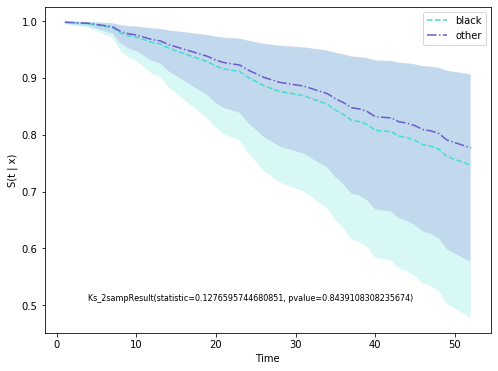

In [105]:
# Race
surv_black = cph.predict_survival_function(df_black)
surv_other = cph.predict_survival_function(df_other)
survival_curve_plot(surv_black, surv_other, label1, label2)

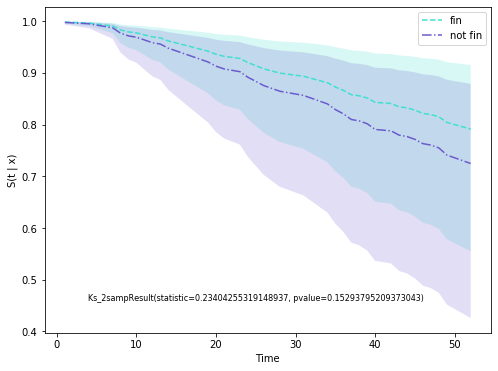

In [106]:
# Received financial aid **
surv_fin = cph.predict_survival_function(df_fin)
surv_not_fin = cph.predict_survival_function(df_not_fin)
survival_curve_plot(surv_fin, surv_not_fin, label3, label4)

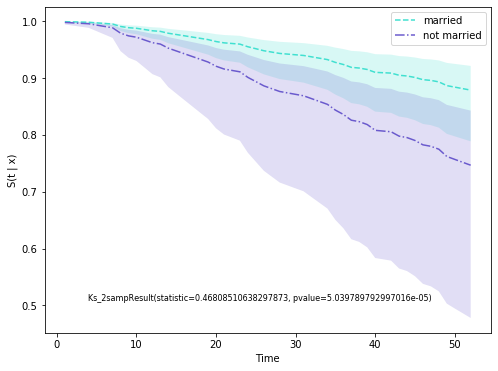

In [107]:
# Married ***
surv_mar = cph.predict_survival_function(df_mar)
surv_not_mar = cph.predict_survival_function(df_not_mar)
survival_curve_plot(surv_mar, surv_not_mar, label5, label6)

### Conditional statistical parity

In [108]:
df1 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 1)]
df2 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]
label1= "black, married, financial aid"
label2= "black, married, not financial aid"

df3 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]
df4 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]
label3= "black, not married, financial aid"
label4= "black, not married, not financial aid"

df5 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 1)]
df6 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]
label5= "other, married, financial aid"
label6= "other, married, not financial aid"

df7 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]
df8 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]
label7= "other, not married, financial aid"
label8= "other, not married, not financial aid"

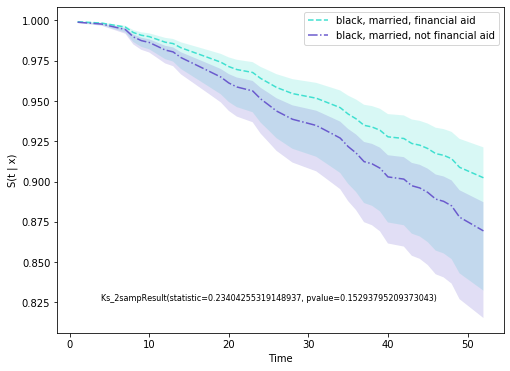

In [109]:
# Black, married, received or not financial aid
surv1 = cph.predict_survival_function(df1)
surv2 = cph.predict_survival_function(df2)
survival_curve_plot(surv1, surv2, label1, label2)

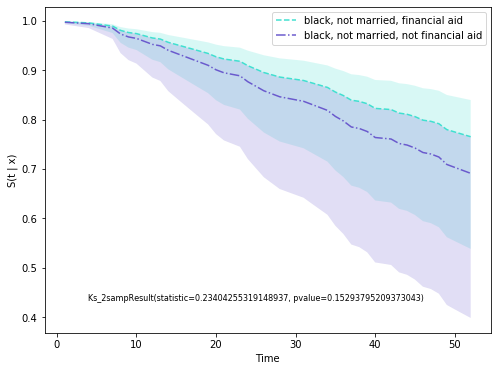

In [110]:
# Black, not married, received or not financial aid **
surv3 = cph.predict_survival_function(df3)
surv4 = cph.predict_survival_function(df4)
survival_curve_plot(surv3, surv4, label3, label4)

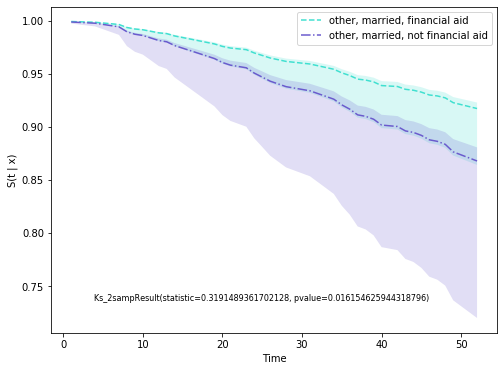

In [111]:
# Other, married, received or not financial aid ****
surv5 = cph.predict_survival_function(df5)
surv6 = cph.predict_survival_function(df6)
survival_curve_plot(surv5, surv6, label5, label6)

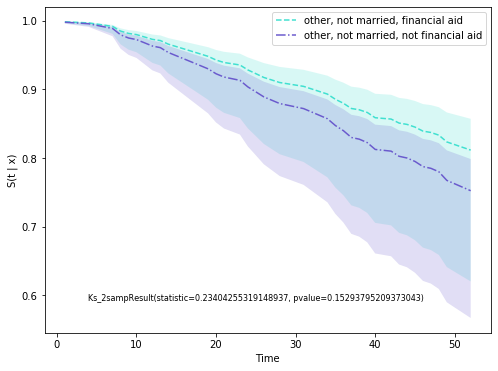

In [112]:
# Other, not married, received or not financial aid ****
surv7 = cph.predict_survival_function(df7)
surv8 = cph.predict_survival_function(df8)
survival_curve_plot(surv7, surv8, label7, label8)

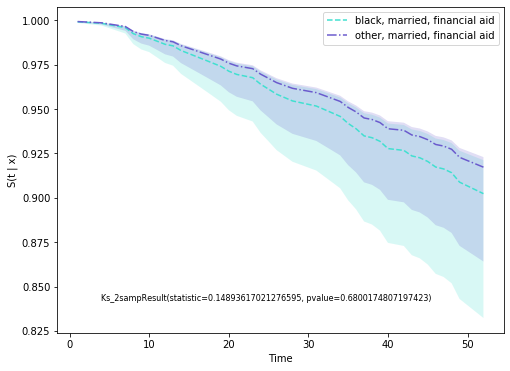

In [113]:
# race, married, received financial aid *****
surv1 = cph.predict_survival_function(df1)
surv5 = cph.predict_survival_function(df5)
survival_curve_plot(surv1, surv5, label1, label5)

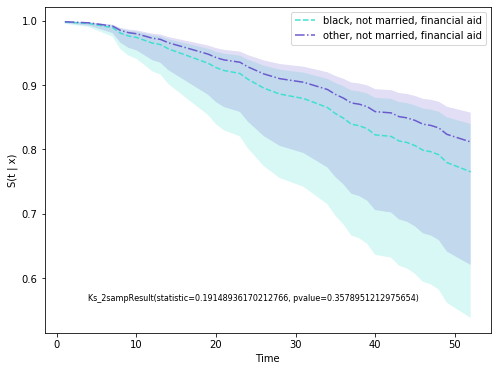

In [114]:
# race, not married, received financial aid ***
surv3 = cph.predict_survival_function(df3)
surv7 = cph.predict_survival_function(df7)
survival_curve_plot(surv3, surv7, label3, label7)

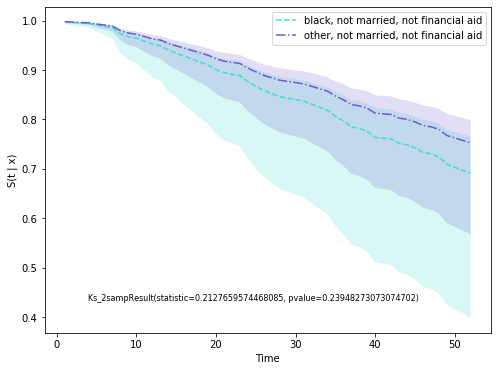

In [115]:
# race, not married, did not receive financial aid 
surv4 = cph.predict_survival_function(df4)
surv8 = cph.predict_survival_function(df8)
survival_curve_plot(surv4, surv8, label4, label8)

### Modified C-Index

In [116]:
from pycox.evaluation import EvalSurv

In [118]:
# pycox time dependent c-index
surv = cph.predict_survival_function(rossi_df)
ev = EvalSurv(surv, rossi_df["week"].to_numpy(), rossi_df["arrest"].to_numpy())
pycox_cindex = ev.concordance_td()
print(pycox_cindex)
print(cph.concordance_index_)

0.6298779381069063


In [119]:
def evaluate_modified_cindex(durations_g1, durations_g2, events_g1, events_g2, surv_g1, surv_g2):
    ev_g1 = EvalSurv(surv_g1, durations_g1, events_g1)
    ev_g2 = EvalSurv(surv_g2, durations_g2, events_g2)

    # c-index
    cindex_g1 = ev_g1.concordance_td()
    cindex_g2 = ev_g2.concordance_td()

    # modified c-index
    cindex_modified_g1 = ev_g1.concordance_td_modified_for_groups(durations_g2, events_g2, surv_g2)
    cindex_modified_g2 = ev_g2.concordance_td_modified_for_groups(durations_g1, events_g1, surv_g1)

    cindex_modified_g1_time_event = ev_g1.concordance_td_modified_for_groups_time_event(durations_g2, events_g2, surv_g2)
    cindex_modified_g2_time_event = ev_g2.concordance_td_modified_for_groups_time_event(durations_g1, events_g1, surv_g1)

    return cindex_g1, cindex_g2, cindex_modified_g1, cindex_modified_g2, cindex_modified_g1_time_event, cindex_modified_g2_time_event


In [120]:
# Race
cindex_black, cindex_other, cindex_modified_black_other, cindex_modified_other_black, cindex_modified_black_other_time_event, cindex_modified_other_black_time_event = evaluate_modified_cindex(df_black["week"].to_numpy(), df_other["week"].to_numpy(), df_black["arrest"].to_numpy(), df_other["arrest"].to_numpy(), surv_black, surv_other)

print(cindex_black, cindex_other) 
print(cindex_modified_black_other[0]/cindex_modified_black_other[1], cindex_modified_black_other)
print(cindex_modified_other_black[0]/cindex_modified_other_black[1], cindex_modified_other_black)
print(cindex_modified_black_other_time_event[0]/cindex_modified_black_other_time_event[1], cindex_modified_black_other_time_event)
print(cindex_modified_other_black_time_event[0]/cindex_modified_other_black_time_event[1], cindex_modified_other_black_time_event)


0.6247924253459578 0.6735880398671097
0.2549675200611387 (1334.5, 5234.0)
0.2964240102171137 (1160.5, 3915.0)
0.7450324799388612 (3899.5, 5234.0)
0.7035759897828864 (2754.5, 3915.0)


In [121]:
# Financial Aid
cindex_fin, cindex_not_fin, cindex_modified_fin, cindex_modified_not_fin, cindex_modified_fin_not_fin_time_event, cindex_modified_not_fin_fin_time_event = evaluate_modified_cindex(df_fin["week"].to_numpy(), df_not_fin["week"].to_numpy(), df_fin["arrest"].to_numpy(), df_not_fin["arrest"].to_numpy(), surv_fin, surv_not_fin)

print(cindex_fin, cindex_not_fin) 
print(cindex_modified_fin[0]/cindex_modified_fin[1], cindex_modified_fin)
print(cindex_modified_not_fin[0]/cindex_modified_not_fin[1], cindex_modified_not_fin)
print(cindex_modified_fin_not_fin_time_event[0]/cindex_modified_fin_not_fin_time_event[1], cindex_modified_fin_not_fin_time_event)
print(cindex_modified_not_fin_fin_time_event[0]/cindex_modified_not_fin_fin_time_event[1], cindex_modified_not_fin_fin_time_event)


0.5932653725192495 0.6324132492113564
0.15708104685521318 (1488.5, 9476.0)
0.34022363965666585 (4320.5, 12699.0)
0.8429189531447868 (7987.5, 9476.0)
0.6597763603433341 (8378.5, 12699.0)


In [122]:
# Married
cindex_mar, cindex_not_mar, cindex_modified_mar, cindex_modified_not_mar, cindex_modified_mar_not_mar_time_event, cindex_modified_not_mar_mar_time_event = evaluate_modified_cindex(df_mar["week"].to_numpy(), df_not_mar["week"].to_numpy(), df_mar["arrest"].to_numpy(), df_not_mar["arrest"].to_numpy(), surv_mar, surv_not_mar)

print(cindex_fin, cindex_not_fin) 
print(cindex_modified_fin[0]/cindex_modified_fin[1], cindex_modified_fin)
print(cindex_modified_not_fin[0]/cindex_modified_not_fin[1], cindex_modified_not_fin)
print(cindex_modified_fin_not_fin_time_event[0]/cindex_modified_fin_not_fin_time_event[1], cindex_modified_fin_not_fin_time_event)
print(cindex_modified_not_fin_fin_time_event[0]/cindex_modified_not_fin_fin_time_event[1], cindex_modified_not_fin_fin_time_event)


0.5932653725192495 0.6324132492113564
0.15708104685521318 (1488.5, 9476.0)
0.34022363965666585 (4320.5, 12699.0)
0.8429189531447868 (7987.5, 9476.0)
0.6597763603433341 (8378.5, 12699.0)


In [123]:
# Race and financial aid
df_black_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["fin"] == 1)]
df_other_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["fin"] == 1)]

surv_black_fin = cph.predict_survival_function(df_black_fin)
surv_other_fin = cph.predict_survival_function(df_other_fin)

cindex_black_fin, cindex_other_fin, cindex_modified_black_fin, cindex_modified_other_fin, cindex_modified_black_fin_time_event, cindex_modified_other_fin_time_event = evaluate_modified_cindex(df_black_fin["week"].to_numpy(), df_other_fin["week"].to_numpy(), df_black_fin["arrest"].to_numpy(), df_other_fin["arrest"].to_numpy(), surv_black_fin, surv_other_fin)

print(cindex_black_fin, cindex_other_fin) 
print(cindex_modified_black_fin[0]/cindex_modified_black_fin[1], cindex_modified_black_fin)
print(cindex_modified_other_fin[0]/cindex_modified_other_fin[1], cindex_modified_other_fin)
print(cindex_modified_black_fin_time_event[0]/cindex_modified_black_fin_time_event[1], cindex_modified_black_fin_time_event)
print(cindex_modified_other_fin_time_event[0]/cindex_modified_other_fin_time_event[1], cindex_modified_other_fin_time_event)


0.5750132065504491 0.7884615384615384
0.24915635545556805 (221.5, 889.0)
0.27346041055718473 (186.5, 682.0)
0.750843644544432 (667.5, 889.0)
0.7265395894428153 (495.5, 682.0)


In [124]:
# Race and no financial aid
df_black_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["fin"] == 0)]
df_other_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["fin"] == 0)]

surv_black_not_fin = cph.predict_survival_function(df_black_not_fin)
surv_other_not_fin = cph.predict_survival_function(df_other_not_fin)

cindex_black_not_fin, cindex_other_not_fin, cindex_modified_black_not_fin, cindex_modified_other_not_fin, cindex_modified_black_not_fin_time_event, cindex_modified_other_not_fin_time_event = evaluate_modified_cindex(df_black_not_fin["week"].to_numpy(), df_other_not_fin["week"].to_numpy(), df_black_not_fin["arrest"].to_numpy(), df_other_not_fin["arrest"].to_numpy(), surv_black_not_fin, surv_other_not_fin)

print(cindex_black_not_fin, cindex_other_not_fin) 
print(cindex_modified_black_not_fin[0]/cindex_modified_black_not_fin[1], cindex_modified_black_not_fin)
print(cindex_modified_other_not_fin[0]/cindex_modified_other_not_fin[1], cindex_modified_other_not_fin)
print(cindex_modified_black_not_fin_time_event[0]/cindex_modified_black_not_fin_time_event[1], cindex_modified_black_not_fin_time_event)
print(cindex_modified_other_not_fin_time_event[0]/cindex_modified_other_not_fin_time_event[1], cindex_modified_other_not_fin_time_event)


0.6327743578857992 0.6008403361344538
0.23233465234595818 (411.0, 1769.0)
0.19984012789768185 (250.0, 1251.0)
0.7676653476540418 (1358.0, 1769.0)
0.8001598721023181 (1001.0, 1251.0)


In [126]:
# race, married and no financial aid
df_black_married_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]
df_other_married_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]

surv_black_married_not_fin = cph.predict_survival_function(df_black_married_not_fin)
surv_other_married_not_fin = cph.predict_survival_function(df_other_married_not_fin)

cindex_black_married_not_fin, cindex_other_married_not_fin, cindex_modified_black_married_not_fin, cindex_modified_other_married_not_fin, cindex_modified_black_married_not_fin_time_event, cindex_modified_other_married_not_fin_time_event = evaluate_modified_cindex(df_black_married_not_fin["week"].to_numpy(), df_other_married_not_fin["week"].to_numpy(), df_black_married_not_fin["arrest"].to_numpy(), df_other_married_not_fin["arrest"].to_numpy(), surv_black_married_not_fin, surv_other_married_not_fin)

print(cindex_black_married_not_fin, cindex_other_married_not_fin) 
print(cindex_modified_black_married_not_fin[0]/cindex_modified_black_married_not_fin[1], cindex_modified_black_married_not_fin)
print(cindex_modified_other_married_not_fin[0]/cindex_modified_other_married_not_fin[1], cindex_modified_other_married_not_fin)
print(cindex_modified_black_married_not_fin_time_event[0]/cindex_modified_black_married_not_fin_time_event[1], cindex_modified_black_married_not_fin_time_event)
print(cindex_modified_other_married_not_fin_time_event[0]/cindex_modified_other_married_not_fin_time_event[1], cindex_modified_other_married_not_fin_time_event)


0.7195121951219512 1.0
0.2391304347826087 (5.5, 23.0)
0.9761904761904762 (20.5, 21.0)
0.7608695652173914 (17.5, 23.0)
0.023809523809523808 (0.5, 21.0)


In [127]:
# race, not married and financial aid
df_black_not_married_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]
df_other_not_married_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]

surv_black_not_married_fin = cph.predict_survival_function(df_black_not_married_fin)
surv_other_not_married_fin = cph.predict_survival_function(df_other_not_married_fin)

cindex_black_not_married_fin, cindex_other_not_married_fin, cindex_modified_black_not_married_fin, cindex_modified_other_not_married_fin, cindex_modified_black_not_married_fin_time_event, cindex_modified_other_not_married_fin_time_event = evaluate_modified_cindex(df_black_not_married_fin["week"].to_numpy(), df_other_not_married_fin["week"].to_numpy(), df_black_not_married_fin["arrest"].to_numpy(), df_other_not_married_fin["arrest"].to_numpy(), surv_black_not_married_fin, surv_other_not_married_fin)

print(cindex_black_not_married_fin, cindex_other_not_married_fin) 
print(cindex_modified_black_not_married_fin[0]/cindex_modified_black_not_married_fin[1], cindex_modified_black_not_married_fin)
print(cindex_modified_other_not_married_fin[0]/cindex_modified_other_not_married_fin[1], cindex_modified_other_not_married_fin)
print(cindex_modified_black_not_married_fin_time_event[0]/cindex_modified_black_not_married_fin_time_event[1], cindex_modified_black_not_married_fin_time_event)
print(cindex_modified_other_not_married_fin_time_event[0]/cindex_modified_other_not_married_fin_time_event[1], cindex_modified_other_not_married_fin_time_event)


0.5586636828644501 0.75
0.21711456859971712 (153.5, 707.0)
0.21641791044776118 (130.5, 603.0)
0.7828854314002829 (553.5, 707.0)
0.7835820895522388 (472.5, 603.0)


In [ ]:
# race, not married and no financial aid
df_black_not_married_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]
df_other_not_married_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]

surv_black_not_married_not_fin = cph.predict_survival_function(df_black_not_married_not_fin)
surv_other_not_married_not_fin = cph.predict_survival_function(df_other_not_married_not_fin)

cindex_black_not_married_not_fin, cindex_other_not_married_not_fin, cindex_modified_black_not_married_not_fin, cindex_modified_other_not_married_not_fin, cindex_modified_black_not_married_not_fin_time_event, cindex_modified_other_not_married_not_fin_time_event = evaluate_modified_cindex(df_black_not_married_not_fin["week"].to_numpy(), df_other_not_married_not_fin["week"].to_numpy(), df_black_not_married_not_fin["arrest"].to_numpy(), df_other_not_married_not_fin["arrest"].to_numpy(), surv_black_not_married_not_fin, surv_other_not_married_not_fin)

print(cindex_black_not_married_not_fin, cindex_other_not_married_not_fin) 
print(cindex_modified_black_not_married_not_fin[0]/cindex_modified_black_not_married_not_fin[1], cindex_modified_black_not_married_not_fin)
print(cindex_modified_other_not_married_not_fin[0]/cindex_modified_other_not_married_not_fin[1], cindex_modified_other_not_married_not_fin)
print(cindex_modified_black_not_married_not_fin_time_event[0]/cindex_modified_black_not_married_not_fin_time_event[1], cindex_modified_black_not_married_not_fin_time_event)
print(cindex_modified_other_not_married_not_fin_time_event[0]/cindex_modified_other_not_married_not_fin_time_event[1], cindex_modified_other_not_married_not_fin_time_event)
